In [11]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from utils import show_images
%matplotlib inline

## calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]]) -> hist

 - **images**：list, 輸入圖，可以一個或多個圖，深度必須為CV_8U或CV_32F，可為任意通道數，但是每張圖的尺寸和深度必須相同。
 - **channels**：直方圖通道清單。This is a list of indexes, where we specify
the index of the channel we want to compute a histogram
for. To compute a histogram of a grayscale
image, the list would be **[0]**. To compute a histogram
for all three red, green, and blue channels, the channels
list would be **[0,1,2]**.
 - **mask**：可有可無的遮罩。If a mask is
provided, a histogram will be computed for masked
pixels only. If we do not have a mask or do not want
to apply one, we can just provide a value of None.
 - **hist**：輸出的直方圖
 - **dims**：直方圖維度，必須為正數且不能超過CV_MAX_DIMS(目前為32)，假設為灰階圖的直方圖，每個像素只有強度資料，此時維度為1。
 - **histSize**：直方圖橫軸(也稱bin)數目。This is the number of bins we want to use
when computing a histogram. Again, this is a list, one
for each channel we are computing a histogram for.
The bin sizes do not all have to be the same. Here is
an example of 32 bins for each channel: [32,32,32].
 - **ranges**：直方圖的強度範圍，以8位元無負號的影像，就是[0,255]。Here we specify The range of possible pixel
values. Normally, this is [0, 256] for each channel, but
if you are using a color space other than RGB (such as
HSV), the ranges might be different.
 - **uniform**：各維度取值是否一致。
 - **accumulate**：如果設定為true的話，在呼叫calcHist()這函式的時候，hist的內容不會被清掉，方便我們做多次的直方圖計算的累加。

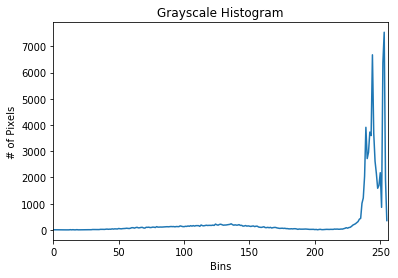

In [2]:
image_dir = "images/trex.png"
image = cv2.imread(image_dir)

image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cv2.imshow("Original", image)

hist = cv2.calcHist([image], [0], None, [256], [0, 256])

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

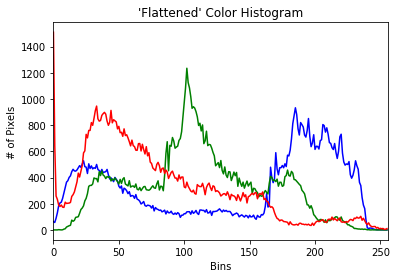

2D histogram shape: (32, 32), with 1024 values


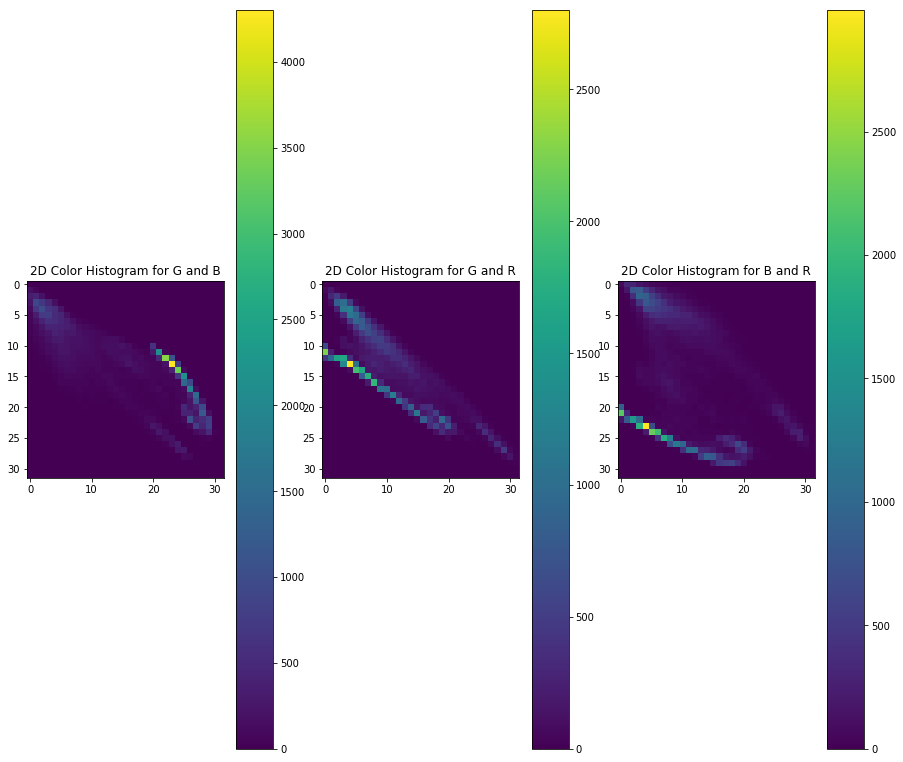

In [5]:
image_dir = "images/beach.png"
image = cv2.imread(image_dir)
cv2.imshow("Original", image)

chans = cv2.split(image)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")

for (chan, color) in zip(chans, colors):
	hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
	plt.plot(hist, color = color)
	plt.xlim([0, 256])

plt.show()
cv2.waitKey(0)

fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(131)
hist = cv2.calcHist([chans[1], chans[0]], [0, 1], None, [32, 32], [0, 256, 0, 256])
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("2D Color Histogram for G and B")
plt.colorbar(p)

ax = fig.add_subplot(132)
hist = cv2.calcHist([chans[1], chans[2]], [0, 1], None, [32, 32], [0, 256, 0, 256])
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("2D Color Histogram for G and R")
plt.colorbar(p)

ax = fig.add_subplot(133)
hist = cv2.calcHist([chans[0], chans[2]], [0, 1], None, [32, 32], [0, 256, 0, 256])
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("2D Color Histogram for B and R")
plt.colorbar(p)

print("2D histogram shape: {}, with {} values".format(hist.shape, hist.flatten().shape[0]))
plt.show()



cv2.destroyAllWindows()

In [6]:
hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
print("3D histogram shape: {}, with {} values".format(hist.shape, hist.flatten().shape[0]))
plt.show()

3D histogram shape: (8, 8, 8), with 512 values


# histogram equalization ([Reference](https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/histogram_equalization/histogram_equalization.html#histogram-equalization))
# 直方圖等化(equalizeHist)

我們可透過拉伸直方圖，使直方圖覆蓋所有強度範圍，這種方法的確能提高影像對比度，但是在多數情況，影像模糊不是因為過窄的強度範圍，而是某區間的像素強度比例過高，這時可以製作一個映射表，使得調整之後的影像，能平均使用所有的強度，進而增加影像的整體對比度。

這就是直方圖等化的概念，以一個8位元強度範圍0~255的影像來說，意味著調整之後的影像，50%的像素強度低於128，25%的像素強度低於64，其他強度比例依此類推。

Histogram equalization improves the contrast of an image
by “stretching” the distribution of pixels. Consider a histogram
with a large peak at the center of it. Applying histogram
equalization will stretch the peak out towards the
corner of the image, thus improving the global contrast of
the image. Histogram equalization is applied to grayscale
images.

This method is useful when an image contains foregrounds
and backgrounds that are both dark or both light. It
tends to produce unrealistic effects in photographs; however,
it is normally useful when enhancing the contrast of
medical or satellite images.

## equalizeHist() 函式可得到直方圖等化後的影像，以下為流程，OpenCV已將流程封裝好，使用時只要直接呼叫 equalizeHist() 函式即可：

 - 計算輸入圖的直方圖。
 - 將直方圖歸一到所有bin的總合為255。
 - 計算直方圖累計表。
 - 用直方圖累計表完成各強度的映射，所以假設強度30所累積的比例為20%，映射的強度即為255*0.2，由於我們直方圖歸一化到255，所以假設強度30所累積的值為20，映射的強度即為20。
 
 <img src="images/HistogramEqualization.png">

Notice how the contrast of the image has been radically changed and now spans the entire range of [0, 255]


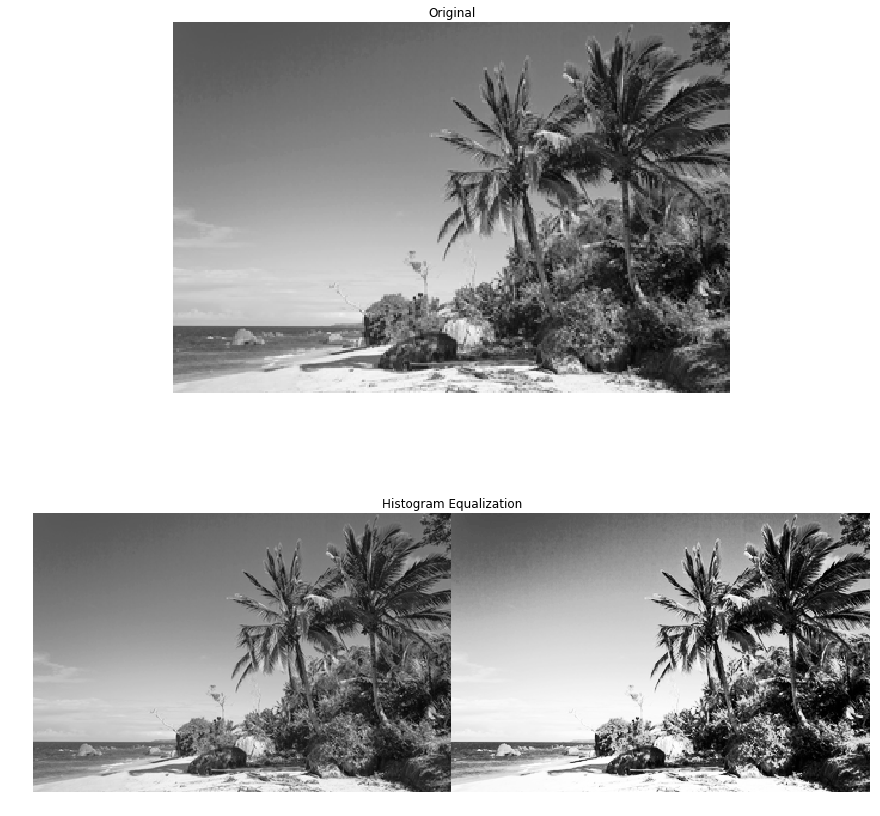

In [15]:
image_dir = "images/beach.png"
image = cv2.imread(image_dir)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# cv2.imshow("Original", image)

eq = cv2.equalizeHist(image)
compare =  np.hstack([image, eq])

# cv2.imshow("Histogram Equalization", np.hstack([image, eq]))
# cv2.waitKey(0)
# cv2.destroyAllWindows()
print('Notice how the contrast of the image has been radically changed and now spans the entire range of [0, 255]')
show_images([image, compare], ['Original', 'Histogram Equalization'],figsize=(15,15))

# Histograms and Masks

In [25]:
def plot_histogram(image, title, mask = None):
	chans = cv2.split(image)
	colors = ("b", "g", "r")
	plt.figure()
	plt.title(title)
	plt.xlabel("Bins")
	plt.ylabel("# of Pixels")
	for (chan, color) in zip(chans, colors):
		hist = cv2.calcHist([chan], [0], mask, [256], [0, 256])
		plt.plot(hist, color = color)
		plt.xlim([0, 256])
        


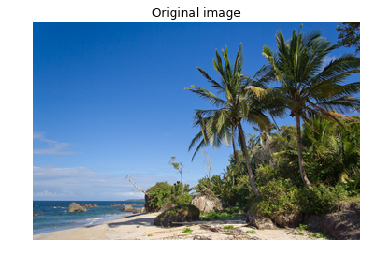

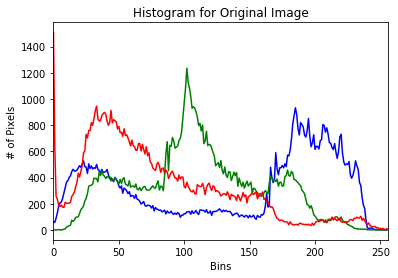

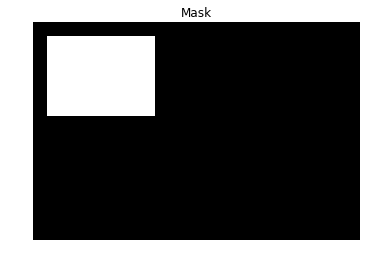

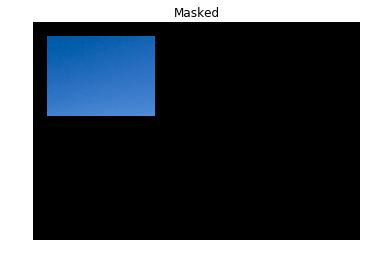

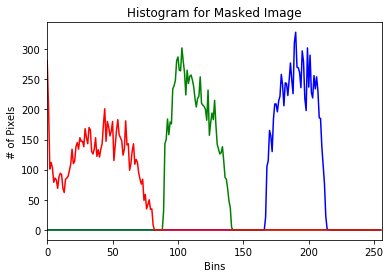


Most red pixels fall in the range [0, 80], indicating that red pixels
contribute very little to our image. This makes sense, since
our sky is blue. Green pixels are then present, but again,
are towards the darker end of the RGB spectrum. Finally,
our blue pixels fall in the brighter range and are obviously
our blue sky.


In [28]:
image_dir = "images/beach.png"
image = cv2.imread(image_dir)
cv2.imshow("Original", image)
cv2.waitKey(0)
show(image, 'Original image')
plot_histogram(image, "Histogram for Original Image")
plt.show()

mask = np.zeros(image.shape[:2], dtype = "uint8")
cv2.rectangle(mask, (15, 15), (130, 100), 255, -1)
cv2.imshow("Mask", mask)
show(mask, "Mask")

masked = cv2.bitwise_and(image, image, mask = mask)
cv2.imshow("Applying the Mask", masked)
cv2.waitKey(0)
show(masked, "Masked")

plot_histogram(image, "Histogram for Masked Image", mask = mask)
plt.show()


print('''
Most red pixels fall in the range [0, 80], indicating that red pixels
contribute very little to our image. This makes sense, since
our sky is blue. Green pixels are then present, but again,
are towards the darker end of the RGB spectrum. Finally,
our blue pixels fall in the brighter range and are obviously
our blue sky.''')
cv2.destroyAllWindows()